In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.get_dataset_names()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'dowjones',
 'exercise',
 'flights',
 'fmri',
 'geyser',
 'glue',
 'healthexp',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'seaice',
 'taxis',
 'tips',
 'titanic']

In [3]:
df = sns.load_dataset('flights')
df.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


## Create, and set as index, the Date column

In [4]:
df['Date'] = pd.to_datetime("01-" + df.month.astype(str) + df.year.astype(str))
df.set_index('Date', inplace=True)
df.head()

,year,month,passengers
Date,,,
1949-01-01,1949,Jan,112
1949-02-01,1949,Feb,118
1949-03-01,1949,Mar,132
1949-04-01,1949,Apr,129
1949-05-01,1949,May,121


In [5]:
flight_df = df[['passengers']]
flight_df.head()

,passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [6]:
flight_df.shape

(144, 1)

In [7]:
# check for null values
flight_df.isna().sum()

passengers    0
dtype: int64

## Stationarity Check and Visualisation

<Axes: xlabel='Date', ylabel='passengers'>

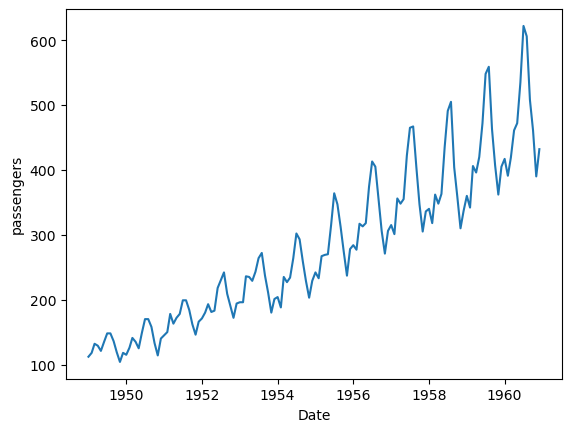

In [8]:
sns.lineplot(data=flight_df, x='Date', y=flight_df['passengers'])

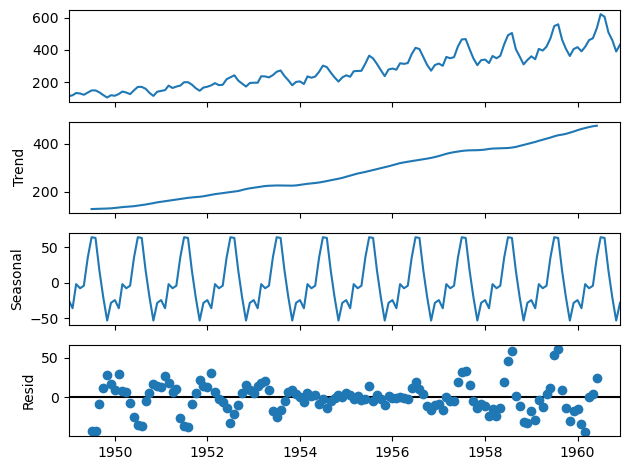

In [9]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(flight_df)
decomposition.plot();

- The decomposition plot shows
    - linear upward trend
    - yearly seasonality
- The series is not stationary

### Adfuller test to confirm nonstationarity

In [10]:
from statsmodels.tsa.stattools import adfuller

In [11]:
def stationarity_check(df, col, alpha=0.05):
    adf = adfuller(df[col], autolag="AIC")
    if adf[1] < alpha:
        concl = f"Stationary at {alpha*100} %"
    else: concl = f"Non-stationary at {alpha*100} %"
    stats = pd.Series(adf[0:4], index=['Test Statistic', 'p-value', 'lags used', 'number of obs'])
    print(stats)
    
    for key, val in adf[4].items():
        print(f"{key}: \t {val}")
        
    sns.lineplot(data=df, x=df.index, y=col).set(title=concl)

Test Statistic      0.815369
p-value             0.991880
lags used          13.000000
number of obs     130.000000
dtype: float64
1%: 	 -3.4816817173418295
5%: 	 -2.8840418343195267
10%: 	 -2.578770059171598


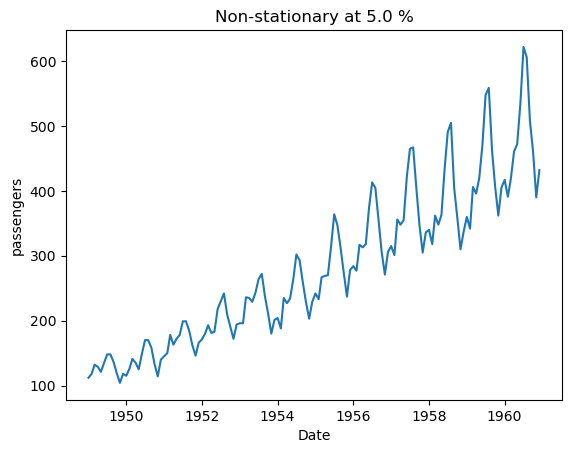

In [12]:
stationarity_check(flight_df, "passengers")

- high $p$-value of 0.99 shows non-stationarity at 1%, 5%, and 10%

## Stationarisation
- differencing is required to remove trend
- seasonal differencing is required to remove seasonalality
- transformation is required to stabilise the variance
    - log
    - sqrt
    - cuberoot

In [13]:
# take first difference
flight_df['first_diff'] = flight_df['passengers'].diff()
# take 12-lag difference
flight_df['twelve_diff'] = flight_df['passengers'].diff(12)
# take logs 
flight_df['log'] = np.log(flight_df['passengers'])
# take sqrt
flight_df['sqrt'] = np.sqrt(flight_df['passengers'])
# take log then difference
flight_df['log_diff'] = np.log(flight_df['passengers']).diff(1)
# take log then difference then 12-lag difference
flight_df['log_diff_twelve'] = np.log(flight_df['passengers']).diff(1).diff(12)
# take sqrt then difference 
flight_df['sqrt_diff'] = np.sqrt(flight_df['passengers']).diff(1)
# take sqrt then difference then 12-lag difference
flight_df['sqrt_diff_twelve'] = np.sqrt(flight_df['passengers']).diff(1).diff(12)

In [14]:
flight_df.head()

,passengers,first_diff,twelve_diff,log,sqrt,log_diff,log_diff_twelve,sqrt_diff,sqrt_diff_twelve
Date,,,,,,,,,
1949-01-01,112,NaN,NaN,4.718499,10.583005,NaN,NaN,NaN,NaN
1949-02-01,118,6.0,NaN,4.770685,10.862780,0.052186,NaN,0.279775,NaN
1949-03-01,132,14.0,NaN,4.882802,11.489125,0.112117,NaN,0.626345,NaN
1949-04-01,129,-3.0,NaN,4.859812,11.357817,-0.022990,NaN,-0.131309,NaN
1949-05-01,121,-8.0,NaN,4.795791,11.000000,-0.064022,NaN,-0.357817,NaN


In [15]:
flight_df.columns

Index(['passengers', 'first_diff', 'twelve_diff', 'log', 'sqrt', 'log_diff',
       'log_diff_twelve', 'sqrt_diff', 'sqrt_diff_twelve'],
      dtype='object')

Test Statistic     -2.644025
p-value             0.084235
lags used          12.000000
number of obs     118.000000
dtype: float64
1%: 	 -3.4870216863700767
5%: 	 -2.8863625166643136
10%: 	 -2.580009026141913


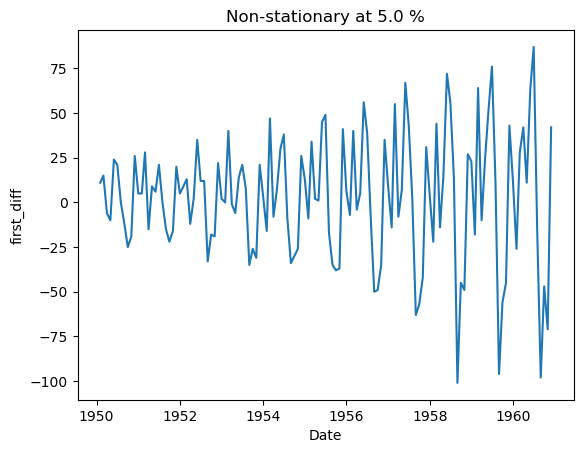

In [16]:
# check stationarity for each transformation
cols = ['first_diff', 'twelve_diff', 'log', 'sqrt', 'log_diff', 'log_diff_twelve', 'sqrt_diff', 'sqrt_diff_twelve']
stationarity_check(flight_df.dropna(), cols[0])

Test Statistic     -3.375189
p-value             0.011834
lags used           1.000000
number of obs     129.000000
dtype: float64
1%: 	 -3.482087964046026
5%: 	 -2.8842185101614626
10%: 	 -2.578864381347275


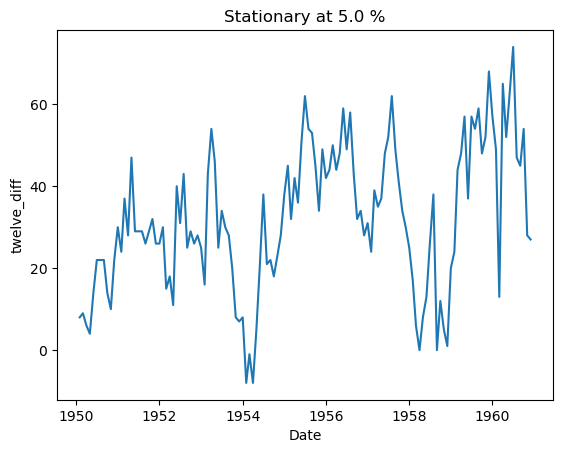

In [17]:
stationarity_check(flight_df.dropna(), cols[1])

Test Statistic     -1.179453
p-value             0.682371
lags used          13.000000
number of obs     117.000000
dtype: float64
1%: 	 -3.487517288664615
5%: 	 -2.8865777180380032
10%: 	 -2.5801239192052012


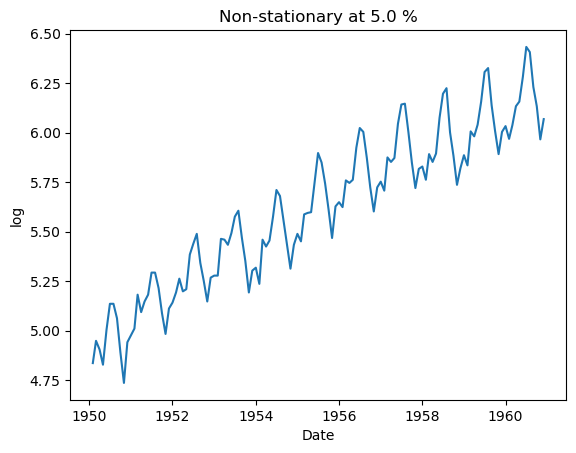

In [18]:
stationarity_check(flight_df.dropna(), cols[2])

Test Statistic     -2.813539
p-value             0.056366
lags used          12.000000
number of obs     118.000000
dtype: float64
1%: 	 -3.4870216863700767
5%: 	 -2.8863625166643136
10%: 	 -2.580009026141913


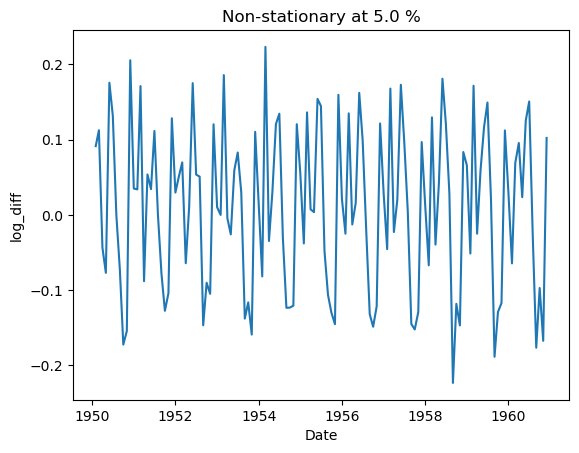

In [19]:
stationarity_check(flight_df.dropna(), cols[4])

Test Statistic     -4.443325
p-value             0.000249
lags used          12.000000
number of obs     118.000000
dtype: float64
1%: 	 -3.4870216863700767
5%: 	 -2.8863625166643136
10%: 	 -2.580009026141913


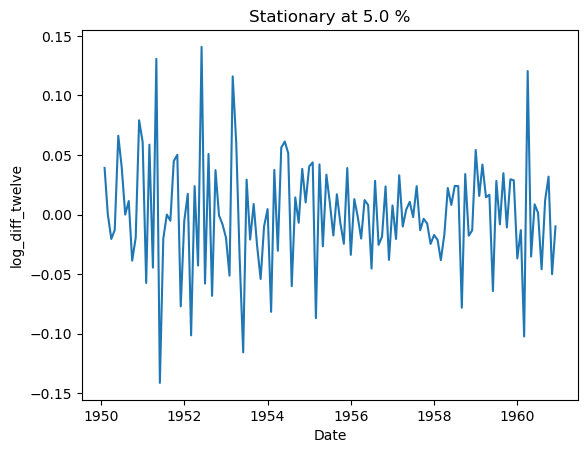

In [20]:
stationarity_check(flight_df.dropna(), cols[5])

Test Statistic     -2.889439
p-value             0.046590
lags used          12.000000
number of obs     118.000000
dtype: float64
1%: 	 -3.4870216863700767
5%: 	 -2.8863625166643136
10%: 	 -2.580009026141913


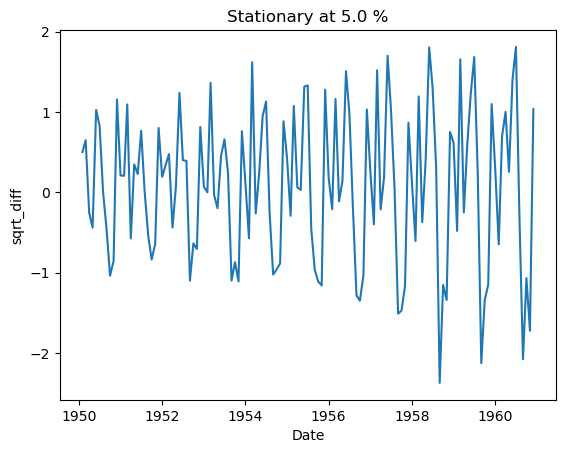

In [21]:
stationarity_check(flight_df.dropna(), cols[6])

Test Statistic     -4.274286
p-value             0.000492
lags used          11.000000
number of obs     119.000000
dtype: float64
1%: 	 -3.4865346059036564
5%: 	 -2.8861509858476264
10%: 	 -2.579896092790057


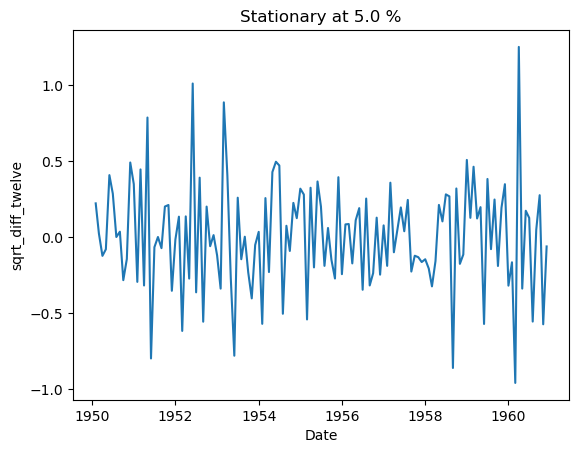

In [22]:
stationarity_check(flight_df.dropna(), cols[7])

- Stationary:
    - $\texttt{twelve\_diff}$ is stationary with slight persistent trend with $p$-value = 0.011834
    - $\texttt{log\_diff\_twelve}$ is stationary with $p$-value = 0.000249
    - $\texttt{sqrt\_diff}$ is stationary with slight persistent seasonality $p$-value = 0.046590
    - $\texttt{sqrt\_diff\_twelve}$ is stationary with $p$-value = 0.000492
- Notes:
    - Both single and lag-12 differencing is needed to remove trend and seasonality
    - Both $\log$ and $\texttt{sqrt}$ remove the change in variation in the series
    - $\log$ has a slightly lower $p$-value but this difference is not enough to separate the two
    - SARIMA models will be fitted with both transformations

In [23]:
stationary_flight = flight_df[['passengers','log','sqrt','log_diff_twelve', 'sqrt_diff_twelve']]
stationary_flight

,passengers,log,sqrt,log_diff_twelve,sqrt_diff_twelve
Date,,,,,
1949-01-01,112,4.718499,10.583005,NaN,NaN
1949-02-01,118,4.770685,10.862780,NaN,NaN
1949-03-01,132,4.882802,11.489125,NaN,NaN
1949-04-01,129,4.859812,11.357817,NaN,NaN
1949-05-01,121,4.795791,11.000000,NaN,NaN
...,...,...,...,...,...
1960-08-01,606,6.406880,24.617067,-0.045934,-0.556642
1960-09-01,508,6.230481,22.538855,0.012024,0.047534
1960-10-01,461,6.133398,21.470911,0.031830,0.275249


## Model Selection: finding p, d, q, P, D, Q, s
- Clearly s=12
- We found d=1, D=1
- ACF and PACF will be used to find p, q, P, Q

In [24]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

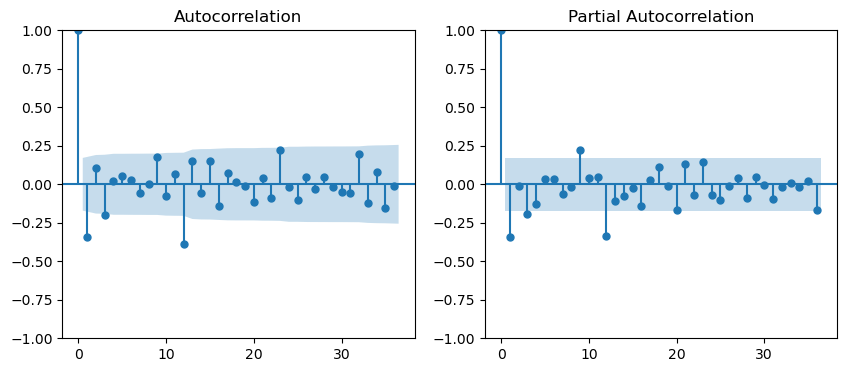

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_acf(stationary_flight['log_diff_twelve'].dropna(), lags=36, ax=axes[0]);
plot_pacf(stationary_flight['log_diff_twelve'].dropna(), lags=36, ax=axes[1]);

For $\texttt{log\_diff\_twelve}$:
- q = 3
- p = 3, with significance at lag 9
- Q = 1
- P = 1
Therefore the model is:
- $ARIMA(3, 1, 3)(1, 1, 1)_{12}$

In [26]:
train = stationary_flight[:116]
test = stationary_flight[116:]

In [27]:
model = SARIMAX(train['log'], order=(3,1,3), seasonal_order=(1,1,1,12)).fit()

C:\Users\bduma\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\bduma\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\bduma\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


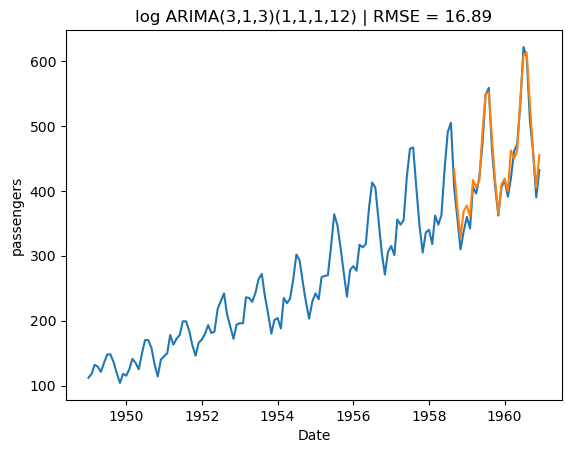

In [28]:
pred = model.predict(start=test.index[0], end=test.index[-1])
exp_pred = np.exp(pred)
stationary_flight['log_predict'] = exp_pred
error = np.sqrt(mean_squared_error(test['passengers'], exp_pred))
sns.lineplot(data=stationary_flight, x=stationary_flight.index, y='passengers')
sns.lineplot(data=stationary_flight, x=stationary_flight.index, y='log_predict').set(title=f"log ARIMA(3,1,3)(1,1,1,12) | RMSE = {np.round(error, 2)}")
plt.show()

### Diagnostics

(array([-4110., -4018., -3928., -3837., -3745., -3653., -3562., -3471.,
        -3379., -3287.]),
 [Text(-4110.0, 0, '1958-10'),
  Text(-4018.0, 0, '1959-01'),
  Text(-3928.0, 0, '1959-04'),
  Text(-3837.0, 0, '1959-07'),
  Text(-3745.0, 0, '1959-10'),
  Text(-3653.0, 0, '1960-01'),
  Text(-3562.0, 0, '1960-04'),
  Text(-3471.0, 0, '1960-07'),
  Text(-3379.0, 0, '1960-10'),
  Text(-3287.0, 0, '1961-01')])

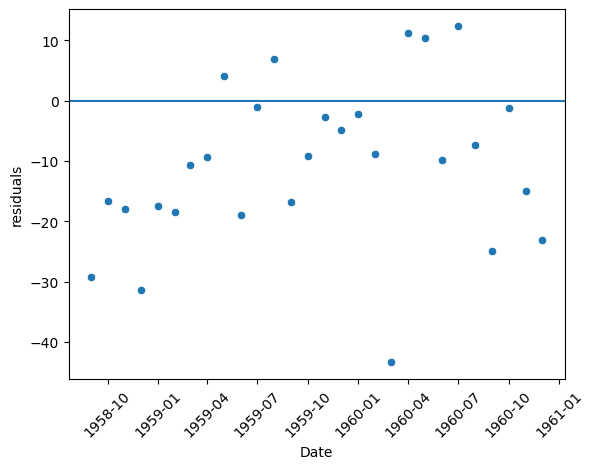

In [29]:
test['residuals'] = test['passengers'] - exp_pred
sns.scatterplot(data=test, x=test.index, y=test.residuals)
plt.axhline(y=0)
plt.xticks(rotation=45)

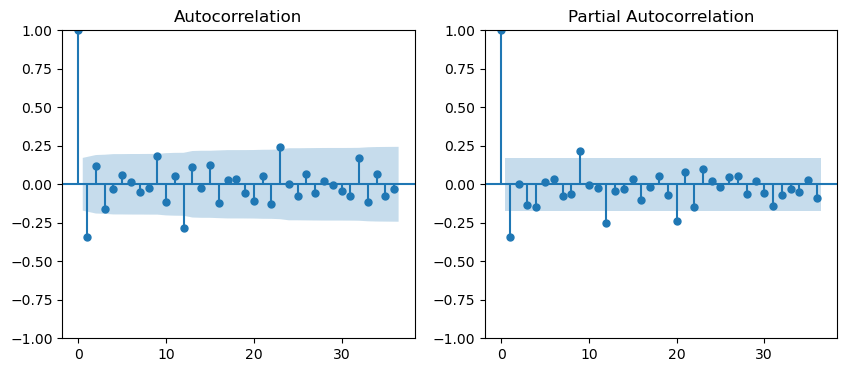

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_acf(stationary_flight['sqrt_diff_twelve'].dropna(), lags=36, ax=axes[0]);
plot_pacf(stationary_flight['sqrt_diff_twelve'].dropna(), lags=36, ax=axes[1]);

For $\texttt{sqrt\_diff\_twelve}$:
- q = 1
- p = 1, with significance at lag 9
- Q = 1
- P = 1
Therefore the model is:
- $ARIMA(1, 1, 1)(1, 1, 1)_{12}$

In [31]:
model_sqrt = SARIMAX(train['sqrt'], order=(1,1,1), seasonal_order=(1,1,1,12)).fit()

C:\Users\bduma\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\bduma\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


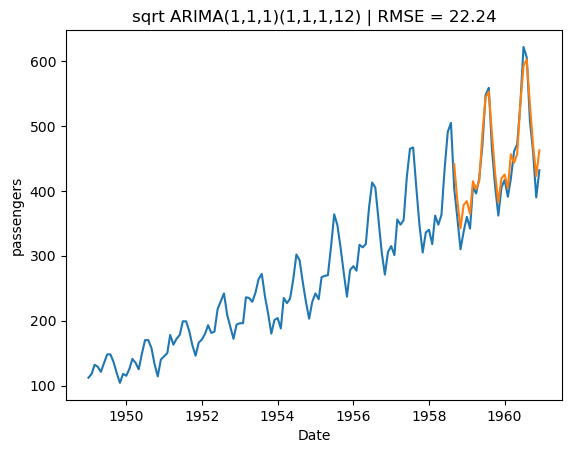

In [32]:
pred_sqrt = model_sqrt.predict(start=test.index[0], end=test.index[-1])
square_pred = pred_sqrt**2
stationary_flight['sqrt_predict'] = square_pred
error = np.sqrt(mean_squared_error(test['passengers'], square_pred))
sns.lineplot(data=stationary_flight, x=stationary_flight.index, y='passengers')
sns.lineplot(data=stationary_flight, x=stationary_flight.index, y='sqrt_predict').set(title=f"sqrt ARIMA(1,1,1)(1,1,1,12) | RMSE = {np.round(error, 2)}")
plt.show()

# Final Model and Forecasting
- the $\log$ model yields a smaller RMSE
- We then choose $\log ARIMA(3,1,3)(1,1,1)_{12}$

In [33]:
stationary_flight.head()

,passengers,log,sqrt,log_diff_twelve,sqrt_diff_twelve,log_predict,sqrt_predict
Date,,,,,,,
1949-01-01,112,4.718499,10.583005,NaN,NaN,NaN,NaN
1949-02-01,118,4.770685,10.862780,NaN,NaN,NaN,NaN
1949-03-01,132,4.882802,11.489125,NaN,NaN,NaN,NaN
1949-04-01,129,4.859812,11.357817,NaN,NaN,NaN,NaN
1949-05-01,121,4.795791,11.000000,NaN,NaN,NaN,NaN


In [34]:
model = SARIMAX(stationary_flight['log'], order=(3,1,3), seasonal_order=(1,1,1,12)).fit()

C:\Users\bduma\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\bduma\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [35]:
forecasts = model.get_forecast(24).summary_frame()

In [36]:
forecasts['dt_mean'] = np.exp(forecasts['mean'])
forecasts['dt_lower'] = np.exp(forecasts['mean_ci_lower'])
forecasts['dt_upper'] = np.exp(forecasts['mean_ci_upper'])

In [37]:
forecasts

log,mean,mean_se,mean_ci_lower,mean_ci_upper,dt_mean,dt_lower,dt_upper
1961-01-01,6.111134,0.035568,6.041422,6.180847,450.849872,420.490390,483.401314
1961-02-01,6.054462,0.041568,5.972989,6.135934,426.009523,392.677784,462.170567
1961-03-01,6.180627,0.048055,6.086441,6.274812,483.294693,439.853167,531.026665
1961-04-01,6.202958,0.051193,6.102621,6.303295,494.208527,447.027678,546.369005
1961-05-01,6.236102,0.053212,6.131808,6.340395,510.863125,460.267613,567.020414
1961-06-01,6.372831,0.056119,6.262840,6.482822,585.713773,524.707116,653.813553
1961-07-01,6.511761,0.059181,6.395768,6.627755,673.010846,599.303434,755.783420
1961-08-01,6.509796,0.061538,6.389184,6.630408,671.689658,595.370782,757.791632
1961-09-01,6.329911,0.063757,6.204949,6.454873,561.106469,495.193618,635.792664
1961-10-01,6.212713,0.066173,6.083016,6.342409,499.053127,438.349318,568.163365


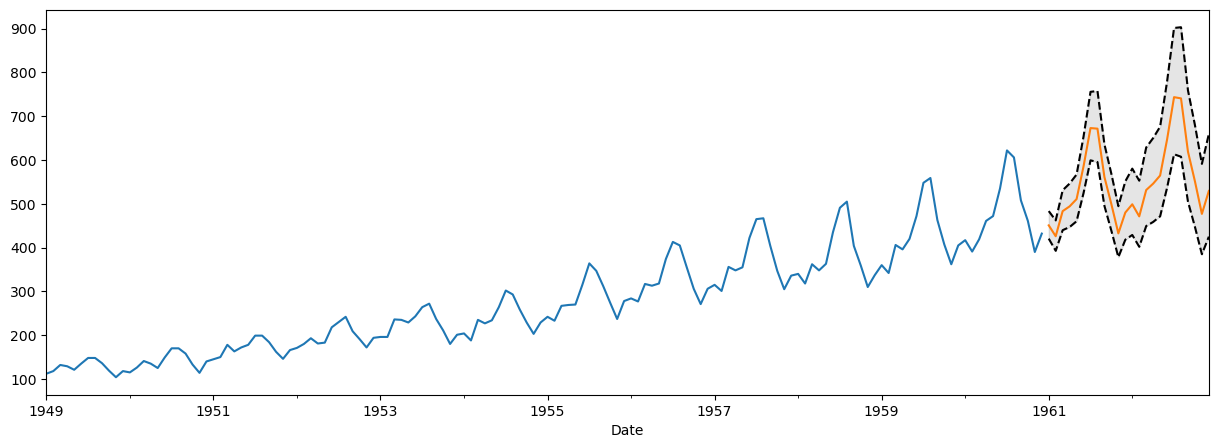

In [38]:
fig, ax = plt.subplots(figsize=(15, 5))
stationary_flight['passengers'].plot(ax=ax)
forecasts['dt_mean'].plot(ax=ax)
forecasts['dt_lower'].plot(ax=ax, style='k--')
forecasts['dt_upper'].plot(ax=ax, style='k--')
ax.fill_between(forecasts.index, forecasts['dt_lower'], forecasts['dt_upper'], color='k', alpha=0.1);